# **Solar Energy Generation Prediction Pipeline - Full Walkthrough**

This notebook provides a complete, step-by-step walkthrough of the solar energy prediction pipeline. It covers everything from understanding the raw datasets, cleaning and transforming the data, merging meteorological features, training two machine learning models (Linear Regression and Random Forest Regressor), evaluating their performance, and analysing the results through visualisations.

---

**Datasets Used:**
- **EMHIRES Solar PV Dataset** - Hourly solar capacity factors for 29 European countries (1986-2015), published by the European Commission Joint Research Centre.
- **NASA POWER Hourly Weather Data** - Hourly meteorological variables (Irradiance, Temperature, Wind Speed) fetched via the NASA POWER API for each country's geographic centroid (2001-2015).

**Models Trained:**
- Linear Regression
- Random Forest Regressor

**Target Variable:** `Capacity_Factor` - A value between 0.0 and 1.0 representing how efficiently a solar panel converts available sunlight into electricity at a given hour.

---
## **Pipeline Overview**

The end-to-end pipeline follows this sequence:

1. **Import Libraries** - Load all necessary Python packages.
2. **Load and Explore the Dataset** - Read the EMHIRES CSV and understand its structure.
3. **Visualise the Raw Data** - Plot a single day's solar cycle to build intuition.
4. **NASA POWER Data Fetching (Reference)** - Document how the weather data was collected (not executed here).
5. **Data Cleaning and Quality Checks** - Verify data integrity before processing.
6. **Data Structuralization and Temporal Validation** - Reshape the dataset, create timestamps, extract features.
7. **Master Dataset Integration and Memory Optimization** - Merge generation data with NASA weather data.
8. **Categorical Encoding (One-Hot Encoding)** - Convert country labels into numerical features.
9. **Training and Evaluation (Linear Regression)** - Train the first model and measure performance.
10. **Model Export (Linear Regression)** - Save the trained model to disk.
11. **Analysis and Visualisation (Linear Regression)** - Detailed graphical analysis of model performance.
12. **Training and Evaluation (Random Forest Regressor)** - Train the second model and measure performance.
13. **Model Export (Random Forest Regressor)** - Save the trained model to disk.
14. **Analysis and Visualisation (Random Forest Regressor)** - Detailed graphical analysis of model performance.
15. **Custom Prediction Example** - Demonstrate how to use a trained model for inference.

---
## **1. Importing Libraries**

All required libraries are loaded upfront. These cover data manipulation (`pandas`, `numpy`), visualisation (`matplotlib`, `seaborn`), machine learning (`scikit-learn`), model persistence (`joblib`), and memory management (`gc`).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import gc
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

---
## **2. Loading and Exploring the EMHIRES Dataset**

The EMHIRES PV dataset (`EMHIRESPV_TSh_CF_Country_19862015.csv`) contains hourly solar capacity factors for 29 European countries spanning 1986 to 2015. Each column represents a country (using its two-letter ISO code), and each row represents one hour of data. The values range from 0.0 (no solar production) to 1.0 (maximum theoretical output).

The dataset is structured in **wide format** - every country is a separate column. This is convenient for quick country-level lookups but must be reshaped before machine learning.

In [2]:
df = pd.read_csv('EMHIRESPV_TSh_CF_Country_19862015.csv')
print(f"Dataset Shape: {df.shape}")
print(f"Countries: {list(df.columns)}")
print(f"Total Hours Recorded: {len(df):,}")
df.head(15)

Dataset Shape: (262968, 29)
Countries: ['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'EL', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'NL', 'NO', 'PL', 'PT', 'RO', 'SI', 'SK', 'SE', 'UK']
Total Hours Recorded: 262,968


,AT,BE,BG,CH,CY,CZ,DE,DK,EE,ES,...,LV,NL,NO,PL,PT,RO,SI,SK,SE,UK
0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.052450,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.015086,0.000000,0.059359,0.000000,0.024719,0.000000,0.000000
8,0.117483,0.000000,0.135141,0.068950,0,0.069215,0.019261,0.000000,0.030179,0.043921,...,0.043222,0.000000,0.000000,0.065217,0.000000,0.098980,0.048753,0.180386,0.000000,0.000000
9,0.166434,0.064906,0.206412,0.152344,0,0.127238,0.069999,0.044591,0.074671,0.146012,...,0.089203,0.058231,0.020474,0.108220,0.125138,0.111118,0.052076,0.238421,0.039335,0.047485


---
## **3. Visualising the Raw Data -- A Single Day's Solar Cycle**

Before any transformation, it is important to understand what the raw data looks like. The plot below shows 24 hours of solar capacity factor data for Spain (ES). This reveals the natural "heartbeat" of solar production: zero output at night, a ramp-up at sunrise, a peak at solar noon, and a ramp-down at sunset.

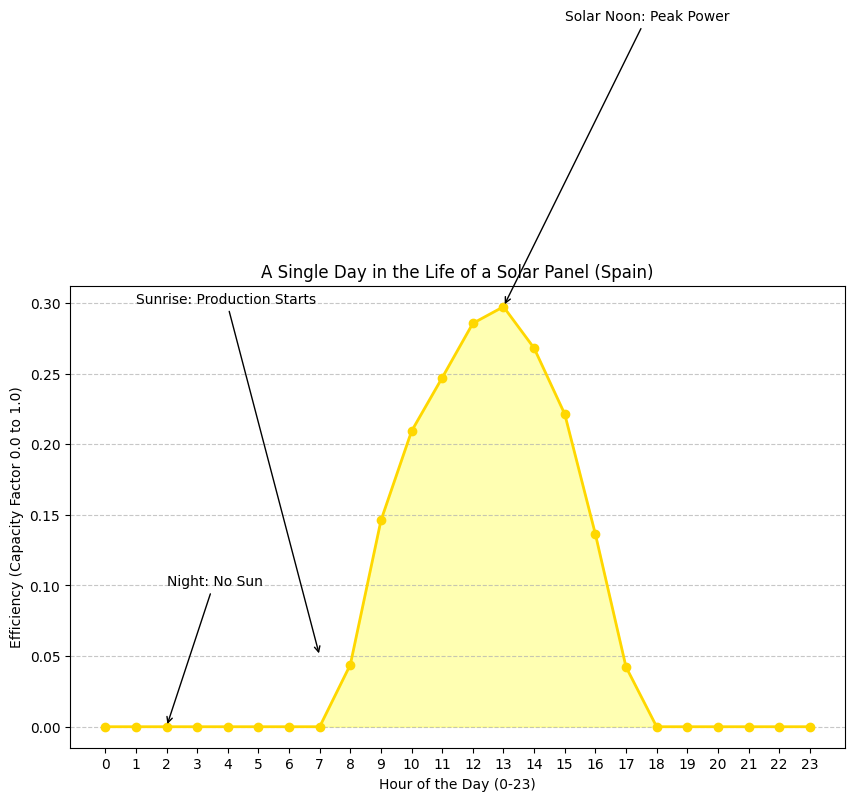

In [3]:
one_day = df['ES'].iloc[0:24]

plt.figure(figsize=(10, 6))
plt.plot(one_day, marker='o', color='gold', linewidth=2, label='Solar Efficiency')
plt.fill_between(range(24), one_day, color='yellow', alpha=0.3)

plt.annotate('Night: No Sun', xy=(2, 0), xytext=(2, 0.1), arrowprops=dict(arrowstyle='->'))
plt.annotate('Sunrise: Production Starts', xy=(7, 0.05), xytext=(1, 0.3), arrowprops=dict(arrowstyle='->'))
plt.annotate('Solar Noon: Peak Power', xy=(13, one_day.max()), xytext=(15, 0.5), arrowprops=dict(arrowstyle='->'))

plt.title('A Single Day in the Life of a Solar Panel (Spain)')
plt.ylabel('Efficiency (Capacity Factor 0.0 to 1.0)')
plt.xlabel('Hour of the Day (0-23)')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **Interpreting the Solar Lifecycle**

The plot above illustrates the fundamental physics that drive the data:

**The Zero Line (Nighttime):** From hour 0 to approximately hour 7, and again from hour 18 to 23, the capacity factor is 0.00. No solar radiation reaches the panels during these hours.

**The Ramping Phase (Sunrise):** Starting around hour 7, there is a sharp ramp-up. This is the moment the sun crosses the horizon and irradiance begins converting into electrical current.

**Solar Noon (The Peak):** The curve peaks around hour 13. This is the point of maximum capacity factor, when the sun is at its highest angle in the sky, providing the most intense irradiance.

**The Ramping Phase (Sunset):** After the peak, production gradually ramps down as the sun descends, eventually returning to zero.

This daily cycle is the core pattern that the machine learning models will learn to predict.

---
## **4. NASA POWER Weather Data (Reference Only)**

The weather data used in this pipeline was fetched from the NASA POWER API. The script below (`nasa.py`) was used to collect hourly Irradiance, Temperature, and Wind Speed for all 29 EMHIRES countries from 2001 to 2015. The fetched data is saved as `nasa_weather_master.csv`.

**This script is provided for reference only and is not meant to be executed in this notebook.** The fetch process takes approximately 20+ minutes due to the sheer amount of data and API rate limiting. The resulting CSV file is already included in the project and will be loaded directly in the next steps.

```python
import pandas as pd
import requests
import time

# Geographic Centroids for all EMHIRES Countries
countries = {
    'AT': {'lat': 47.51, 'lon': 14.55}, 'BE': {'lat': 50.50, 'lon': 4.47},
    'BG': {'lat': 42.73, 'lon': 25.48}, 'CH': {'lat': 46.81, 'lon': 8.22},
    'CY': {'lat': 35.12, 'lon': 33.42}, 'CZ': {'lat': 49.81, 'lon': 15.47},
    'DE': {'lat': 51.16, 'lon': 10.45}, 'DK': {'lat': 56.26, 'lon': 9.50},
    'EE': {'lat': 58.59, 'lon': 25.01}, 'EL': {'lat': 39.07, 'lon': 21.82},
    'ES': {'lat': 40.46, 'lon': -3.74}, 'FI': {'lat': 61.92, 'lon': 25.74},
    'FR': {'lat': 46.22, 'lon': 2.21},  'HR': {'lat': 45.10, 'lon': 15.20},
    'HU': {'lat': 47.16, 'lon': 19.50}, 'IE': {'lat': 53.41, 'lon': -8.24},
    'IT': {'lat': 41.87, 'lon': 12.56}, 'LT': {'lat': 55.16, 'lon': 23.88},
    'LU': {'lat': 49.81, 'lon': 6.12},  'LV': {'lat': 56.87, 'lon': 24.60},
    'NL': {'lat': 52.13, 'lon': 5.29},  'NO': {'lat': 60.47, 'lon': 8.46},
    'PL': {'lat': 51.91, 'lon': 19.14}, 'PT': {'lat': 39.39, 'lon': -8.22},
    'RO': {'lat': 45.94, 'lon': 24.96}, 'SE': {'lat': 60.12, 'lon': 18.64},
    'SI': {'lat': 46.15, 'lon': 14.99}, 'SK': {'lat': 48.66, 'lon': 19.69},
    'UK': {'lat': 55.37, 'lon': -3.43}
}

all_data = []

print("Starting Data Fetch (2001-2015)... This might take atleast 20 minutes.")

for code, coords in countries.items():
    print(f"Fetching {code}")
    for year in range(2001, 2016):
        url = (f"https://power.larc.nasa.gov/api/temporal/hourly/point?"
               f"parameters=ALLSKY_SFC_SW_DWN,T2M,WS2M&community=RE&longitude={coords['lon']}"
               f"&latitude={coords['lat']}&start={year}0101&end={year}1231&format=JSON")
        try:
            r = requests.get(url, timeout=60)
            if r.status_code == 200:
                json_data = r.json()['properties']['parameter']
                df_year = pd.DataFrame(json_data)
                df_year['Country'] = code
                all_data.append(df_year)
                print(f"  {year} OK")
            else:
                print(f"  {year} Failed (Status: {r.status_code})")
            time.sleep(0.5) # Delay to respect rate limiting
        except Exception as e:
            print(f"  Error on {year}: {e}")

if all_data:
    final_weather = pd.concat(all_data)
    final_weather.index = pd.to_datetime(final_weather.index, format='%Y%m%d%H')
    final_weather.index.name = 'Timestamp'

    # Rename for consistency
    final_weather = final_weather.rename(columns={
        'ALLSKY_SFC_SW_DWN': 'Irradiance',
        'T2M': 'Temperature',
        'WS2M': 'Wind_Speed'
    })

    final_weather.to_csv('nasa_weather_master.csv')
    print("Done.")
```

**What the script does:**
- Iterates over all 29 countries and all years from 2001 to 2015.
- For each country-year combination, it sends a GET request to the NASA POWER Hourly API.
- The API returns three parameters: `ALLSKY_SFC_SW_DWN` (solar irradiance at the surface), `T2M` (temperature at 2 metres), and `WS2M` (wind speed at 2 metres).
- All responses are concatenated into a single DataFrame, timestamps are parsed from the index, columns are renamed for consistency, and the result is saved as `nasa_weather_master.csv`.
- A 0.5-second delay is inserted between requests to respect the API's rate limit.

---
## **5. Data Cleaning and Quality Checks**

Before any transformation, the raw data is inspected for common issues:
- **NASA Sentinel Values (-999):** The NASA POWER API uses -999 as a placeholder when sensor data is unavailable or corrupted.
- **NaN/Null Values:** Standard missing data indicators in pandas.

In [4]:
# Check for NASA -999 flags in the EMHIRES dataset
nasa_flags = (df == -999).sum().sum()

# Check for EMHIRES Null/NaN values
null_values = df.isnull().sum().sum()

print(f"NASA -999 Flags Found: {nasa_flags}")
print(f"Empty/NaN Cells Found: {null_values}")

NASA -999 Flags Found: 0
Empty/NaN Cells Found: 0


### **Interpretation**

Both checks return zero. This indicates that the EMHIRES dataset has been pre-cleaned by the European Commission's Joint Research Centre. Satellite sensor gaps and transmission errors have already been handled upstream, ensuring a continuous and complete time series.

The NASA weather data will be checked separately after the merge step, as that dataset may still contain -999 sentinel values from periods of satellite downtime.

---
## **6. Data Structuralization and Temporal Validation**

This step transforms the raw wide-format EMHIRES data into a machine-learning-ready long format. Three key operations are performed:

### **Dataset Reshaping (Melting)**
The initial dataset has countries as columns. `pd.melt()` transforms this into a long format where:
- A **Country** column holds the two-letter ISO code.
- A **Capacity_Factor** column holds the solar efficiency value.

This is required because the model needs a single target column ($y$) and country as a categorical feature.

### **Temporal Alignment and Truncation**
- **Timestamping:** Every row is mapped to a real-world calendar starting January 1, 1986, at hourly frequency. This accounts for leap years and variable month lengths.
- **Range Truncation (2001-2015):** The data is cropped to start from 2001. This aligns the generation data with the availability window of NASA's hourly solar irradiance data, which only provides reliable hourly resolution from 2001 onward.

### **Feature Extraction**
- **Hour (0-23):** Extracted from the timestamp to give the model diurnal context (time of day).
- **Month (1-12):** Extracted to provide seasonal context.

In [5]:
# Create a verified calendar starting from 1986
start_date = '1986-01-01 00:00:00'
timestamps = pd.date_range(start=start_date, periods=len(df), freq='h')
df['Timestamp'] = timestamps

# Reshape from wide to long format
# Moves countries from columns into rows
df_long = pd.melt(df,
                  id_vars=['Timestamp'],
                  var_name='Country',
                  value_name='Capacity_Factor')

# Remove 1986-2000 to match NASA's Hourly API availability
df_long = df_long[df_long['Timestamp'].dt.year >= 2001]

# Extract temporal features
df_long['Hour'] = df_long['Timestamp'].dt.hour
df_long['Month'] = df_long['Timestamp'].dt.month

print(f"Reshaped Data Shape (2001-2015): {df_long.shape}")
print(f"Countries: {df_long['Country'].nunique()}")
print(f"Date Range: {df_long['Timestamp'].min()} to {df_long['Timestamp'].max()}")
print()
print(df_long[['Timestamp', 'Country', 'Capacity_Factor', 'Hour', 'Month']].head(10))

Reshaped Data Shape (2001-2015): (3812688, 5)
Countries: 29
Date Range: 2001-01-01 00:00:00 to 2015-12-31 23:00:00

                 Timestamp Country  Capacity_Factor  Hour  Month
131496 2001-01-01 00:00:00      AT         0.000000     0      1
131497 2001-01-01 01:00:00      AT         0.000000     1      1
131498 2001-01-01 02:00:00      AT         0.000000     2      1
131499 2001-01-01 03:00:00      AT         0.000000     3      1
131500 2001-01-01 04:00:00      AT         0.000000     4      1
131501 2001-01-01 05:00:00      AT         0.000000     5      1
131502 2001-01-01 06:00:00      AT         0.000000     6      1
131503 2001-01-01 07:00:00      AT         0.000000     7      1
131504 2001-01-01 08:00:00      AT         0.132867     8      1
131505 2001-01-01 09:00:00      AT         0.230769     9      1


---
## **7. Master Dataset Integration and Memory Optimization**

This is the most critical and resource-intensive step. The goal is to fuse 15 years of hourly power generation data with localized meteorological data, creating a single feature matrix of approximately **3.8 million rows**.

### **Why Sequence Matters**

The order of operations is not arbitrary - incorrect sequencing causes catastrophic failures:

1. **The Cartesian Risk:** If One-Hot Encoding is applied *before* the merge, the categorical `Country` column is destroyed. Attempting to merge weather data using only `Timestamp` (without the location key) would cause a Cartesian product explosion, multiplying 3.8 million rows into hundreds of millions and instantly crashing the runtime.

2. **Memory Bloat:** Default Python float types (`float64`) consume double the RAM needed for the precision levels required in atmospheric modelling.

### **Operations Performed**

- **Precision Downcasting:** All NASA meteorological variables (Irradiance, Temperature, Wind Speed) are downcast from `float64` to `float32`, reducing the memory footprint of incoming data by approximately 50%.

- **Composite Key Merging (Inner Join):** The generation data (`df_long`) and weather data (`df_weather`) are merged on `['Timestamp', 'Country']`. This spatial-temporal key ensures that the power output for a specific country at a specific hour is matched with the correct local weather conditions.

- **Post-Merge Cleaning:** Rows with NASA sentinel values (-999.0) or negative irradiance values are filtered out, as these represent sensor failures.

- **Active Garbage Collection:** Intermediate data structures (`df_weather`) are explicitly deleted, and Python's garbage collector is triggered to reclaim freed memory.

In [6]:
# Load NASA Weather Data
df_weather = pd.read_csv('nasa_weather_master.csv')
df_weather['Timestamp'] = pd.to_datetime(df_weather['Timestamp'])

# RAM Optimization: Downcast float64 to float32
float_cols = df_weather.select_dtypes(include=['float64']).columns
df_weather[float_cols] = df_weather[float_cols].astype('float32')

# The Master Merge on [Timestamp, Country]
df_master = pd.merge(df_long, df_weather, on=['Timestamp', 'Country'], how='inner')

# Inspect for data quality issues in the merged dataset
null_counts = df_master[['Irradiance', 'Temperature', 'Wind_Speed']].isnull().sum()
print(f"Standard Null Values (NaN):\n{null_counts}\n")

sentinel_counts = (df_master[['Irradiance', 'Temperature', 'Wind_Speed']] == -999.0).sum()
print(f"NASA Sentinel Placeholders (-999.0):\n{sentinel_counts}\n")

# Filter out sensor errors and invalid readings
df_master = df_master[
    (df_master['Irradiance'] >= 0) &
    (df_master['Temperature'] != -999.0) &
    (df_master['Wind_Speed'] != -999.0)
]

# RAM Cleanup
del df_weather
gc.collect()

print(f"Post-cleaning row count: {len(df_master):,}")
print(f"Final Shape: {df_master.shape}")
df_master.head()

Standard Null Values (NaN):
Irradiance     0
Temperature    0
Wind_Speed     0
dtype: int64

NASA Sentinel Placeholders (-999.0):
Irradiance     0
Temperature    0
Wind_Speed     0
dtype: int64

Post-cleaning row count: 3,812,688
Final Shape: (3812688, 8)


,Timestamp,Country,Capacity_Factor,Hour,Month,Irradiance,Temperature,Wind_Speed
0,2001-01-01 00:00:00,AT,0.0,0,1,0.0,-10.42,0.69
1,2001-01-01 01:00:00,AT,0.0,1,1,0.0,-13.42,1.24
2,2001-01-01 02:00:00,AT,0.0,2,1,0.0,-16.42,1.46
3,2001-01-01 03:00:00,AT,0.0,3,1,0.0,-18.99,1.36
4,2001-01-01 04:00:00,AT,0.0,4,1,0.0,-20.15,1.00


---
## **8. Categorical Encoding (One-Hot Encoding)**

### **The Problem**
Machine learning algorithms, including Linear Regression, cannot interpret string labels like "AT" or "ES". The `Country` column must be converted into a numerical representation.

### **The Solution**
One-Hot Encoding transforms the single `Country` column into 29 binary columns (one per country). For any given row, exactly one country column is set to 1 and the remaining 28 are set to 0.

### **Why This Is Done After Merging**
Encoding is performed *after* the merge to preserve the `Country` column as a usable merge key. If encoding were done before merging, the string-based `Country` key would no longer exist, making it impossible to join generation data with weather data by location.

### **Impact**
This turns a generic global model into a **location-aware** forecast system. The model learns separate baseline weights for each country, capturing geographic differences in solar panel infrastructure, latitude, and local climate patterns.

The encoded dataset is also exported to `merged_encoded.csv` so that subsequent model training steps can load the fully prepared data directly without repeating the cleaning and merging process.

In [7]:
# One-Hot Encoding: Creates Country_AT, Country_BE, ... Country_UK columns
df_master = pd.get_dummies(df_master, columns=['Country'], prefix='Country', dtype=int)

print(f"Encoded Data Shape: {df_master.shape}")
print(f"Country Columns Created: {[col for col in df_master.columns if 'Country_' in col]}")

# Export the merged and encoded dataset for reuse
df_master.to_csv('merged_encoded.csv', index=False)
print("\nSaved merged_encoded.csv")

df_master.head(20)

Encoded Data Shape: (3812688, 36)
Country Columns Created: ['Country_AT', 'Country_BE', 'Country_BG', 'Country_CH', 'Country_CY', 'Country_CZ', 'Country_DE', 'Country_DK', 'Country_EE', 'Country_EL', 'Country_ES', 'Country_FI', 'Country_FR', 'Country_HR', 'Country_HU', 'Country_IE', 'Country_IT', 'Country_LT', 'Country_LU', 'Country_LV', 'Country_NL', 'Country_NO', 'Country_PL', 'Country_PT', 'Country_RO', 'Country_SE', 'Country_SI', 'Country_SK', 'Country_UK']

Saved merged_encoded.csv


,Timestamp,Capacity_Factor,Hour,Month,Irradiance,Temperature,Wind_Speed,Country_AT,Country_BE,Country_BG,...,Country_LV,Country_NL,Country_NO,Country_PL,Country_PT,Country_RO,Country_SE,Country_SI,Country_SK,Country_UK
0,2001-01-01 00:00:00,0.000000,0,1,0.000000,-10.420000,0.69,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2001-01-01 01:00:00,0.000000,1,1,0.000000,-13.420000,1.24,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2001-01-01 02:00:00,0.000000,2,1,0.000000,-16.420000,1.46,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2001-01-01 03:00:00,0.000000,3,1,0.000000,-18.990000,1.36,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2001-01-01 04:00:00,0.000000,4,1,0.000000,-20.150000,1.00,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2001-01-01 05:00:00,0.000000,5,1,0.000000,-19.559999,0.66,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2001-01-01 06:00:00,0.000000,6,1,0.000000,-17.930000,0.65,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2001-01-01 07:00:00,0.000000,7,1,0.000000,-16.430000,0.68,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2001-01-01 08:00:00,0.132867,8,1,46.029999,-14.980000,0.64,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2001-01-01 09:00:00,0.230769,9,1,161.520004,-12.880000,0.35,1,0,0,...,0,0,0,0,0,0,0,0,0,0


---
## **9. Training and Evaluation - Linear Regression**

### **Objective**
Train a Linear Regression model to predict the solar capacity factor from meteorological and temporal features, and quantify its accuracy using standard regression metrics.

### **Feature Engineering**
- **X (Features):** All columns except `Timestamp` (non-numeric) and `Capacity_Factor` (the target). This gives the model: Hour, Month, Irradiance, Temperature, Wind_Speed, and 29 one-hot-encoded country columns - 34 features in total.
- **y (Target):** The `Capacity_Factor` column.

### **Data Partitioning**
The dataset is split into:
- **80% Training** - used to learn patterns from historical data.
- **20% Testing** - held out to validate predictive accuracy on unseen data.

`random_state=67` ensures reproducibility.

### **Evaluation Metrics**
- **Mean Absolute Error (MAE):** The average magnitude of prediction errors, in the same units as the target.
- **Root Mean Squared Error (RMSE):** Similar to MAE but penalises larger errors more heavily.
- **R-Squared ($R^2$):** The proportion of variance in the target that the model explains. A value of 1.0 is perfect; 0.0 means the model is no better than predicting the mean.

In [8]:
# Prepare feature matrix and target vector
X = df_master.drop(columns=['Timestamp', 'Capacity_Factor'])
y = df_master['Capacity_Factor']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Generate predictions on both sets
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

print(f"""Linear Regression - Training Set:
  Mean Absolute Error (MAE):      {mean_absolute_error(y_train, lr_train_pred):.4f}
  Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_train, lr_train_pred)):.4f}
  R-Squared Accuracy:             {r2_score(y_train, lr_train_pred):.4f}

Linear Regression - Testing Set:
  Mean Absolute Error (MAE):      {mean_absolute_error(y_test, lr_test_pred):.4f}
  Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, lr_test_pred)):.4f}
  R-Squared Accuracy:             {r2_score(y_test, lr_test_pred):.4f}
""")

Linear Regression - Training Set:
  Mean Absolute Error (MAE):      0.0532
  Root Mean Squared Error (RMSE): 0.0843
  R-Squared Accuracy:             0.7885

Linear Regression - Testing Set:
  Mean Absolute Error (MAE):      0.0534
  Root Mean Squared Error (RMSE): 0.0845
  R-Squared Accuracy:             0.7880



### **Interpreting the Linear Regression Results**

Linear Regression fits a straight-line relationship between features and the target. Its strength is simplicity and interpretability, but it struggles with non-linear patterns inherent in solar data (e.g., the sharp on/off transition at sunrise and sunset).

Key observations:
- The training and testing metrics should be similar. If they diverge significantly, it indicates overfitting.
- The $R^2$ value indicates how much of the solar generation variance is explained by the features provided.

---
## **10. Exporting the Linear Regression Model**

The trained model is serialised using `joblib` and saved as `solar_model_lr.pkl`. This allows the model to be loaded and used for predictions without retraining.

In [9]:
joblib.dump(lr_model, 'solar_model_lr.pkl')
print("Linear Regression model saved to solar_model_lr.pkl")

Linear Regression model saved to solar_model_lr.pkl


---
## **11. Analysis and Visualisation - Linear Regression**

The following visualisations provide a detailed diagnostic of the Linear Regression model's behaviour. Two figures are generated, each containing two plots:

**Figure 1 - Model Accuracy and Error Analysis:**
- **Actual vs. Predicted Scatter Plot:** Points along the diagonal line indicate perfect predictions. Spread away from the line shows prediction error.
- **Error Distribution (Residuals):** A histogram of prediction errors. A symmetric, narrow bell curve centred at zero indicates a well-calibrated model.

**Figure 2 - Trends and Feature Relationships:**
- **Seasonality and Trends (1 Summer Week in Spain):** Overlays actual generation against model forecasts for 168 consecutive hours (1 week) in July for Spain. This tests whether the model captures diurnal cycling.
- **Correlation Heatmap:** Shows pairwise Pearson correlations between the core numerical features, revealing which variables are most strongly associated with the target.

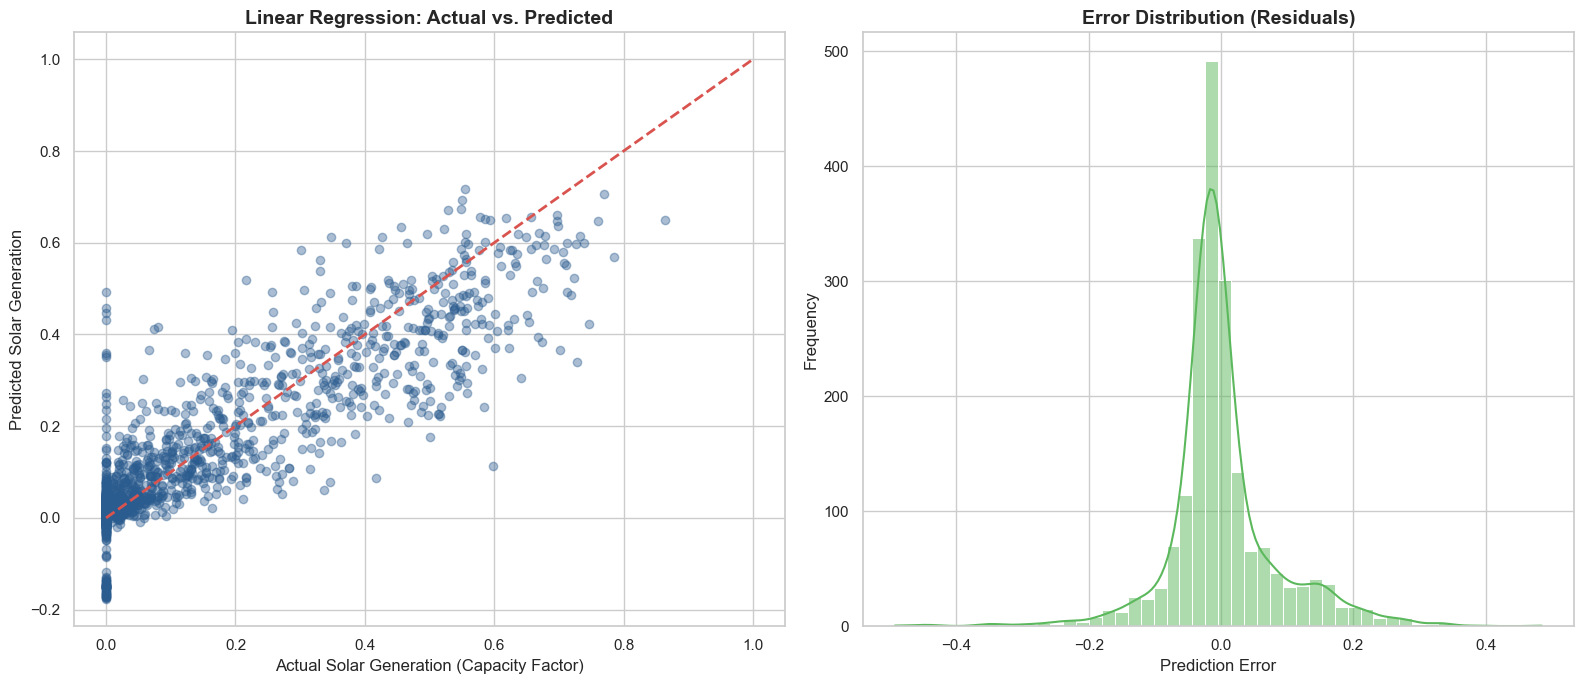

In [10]:
# Reload the model and dataset for analysis
df_analysis_lr = pd.read_csv('merged_encoded.csv')
df_analysis_lr['Timestamp'] = pd.to_datetime(df_analysis_lr['Timestamp'])

X = df_analysis_lr.drop(columns=['Timestamp', 'Capacity_Factor'])
y = df_analysis_lr['Capacity_Factor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)

model_lr = joblib.load('solar_model_lr.pkl')

# Figure 1: Model Accuracy & Error Analysis

sns.set_theme(style="whitegrid")
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Actual vs Predicted
sample_indices = np.random.choice(len(y_test), size=2000, replace=False)
y_test_sample = y_test.iloc[sample_indices]
y_pred_sample = model_lr.predict(X_test.iloc[sample_indices])

axes1[0].scatter(y_test_sample, y_pred_sample, alpha=0.4, color='#2b5c8f')
axes1[0].plot([0, 1], [0, 1], '--', color='#d9534f', linewidth=2)
axes1[0].set_title('Linear Regression: Actual vs. Predicted', fontsize=14, fontweight='bold')
axes1[0].set_xlabel('Actual Solar Generation (Capacity Factor)')
axes1[0].set_ylabel('Predicted Solar Generation')

# Plot 2: Error Distribution (Residuals)
errors = y_test_sample - y_pred_sample
sns.histplot(errors, bins=50, kde=True, ax=axes1[1], color='#5cb85c')
axes1[1].set_title('Error Distribution (Residuals)', fontsize=14, fontweight='bold')
axes1[1].set_xlabel('Prediction Error')
axes1[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

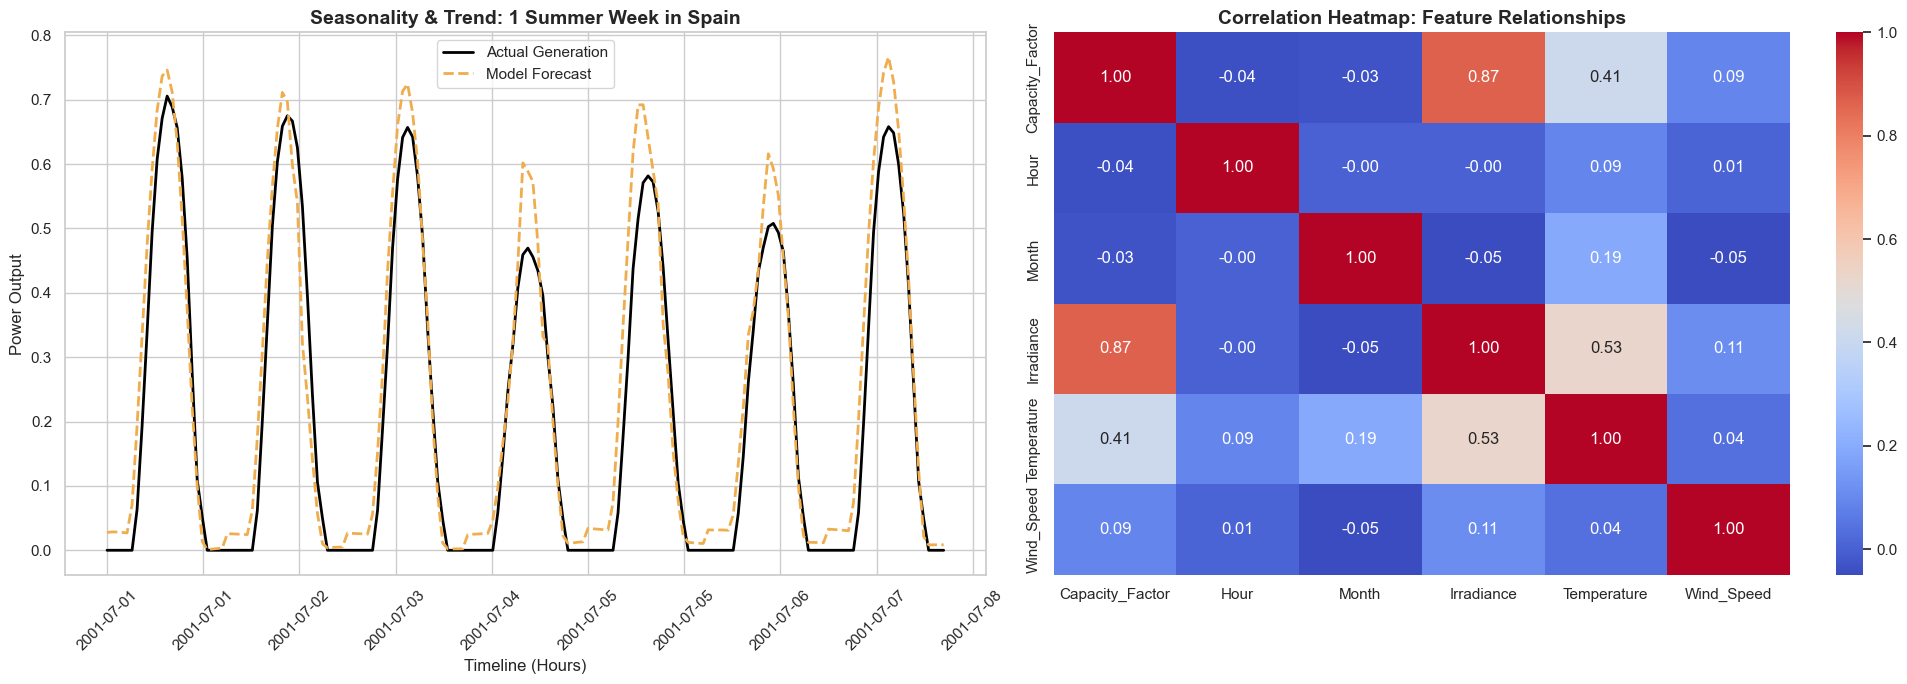

In [11]:
# Figure 2: Trends & Feature Relationships

fig2, axes2 = plt.subplots(1, 2, figsize=(20, 7))

# Plot 3: Seasonality & Trends (1 Summer Week in Spain)
spain_summer = df_analysis_lr[(df_analysis_lr['Country_ES'] == 1) & (df_analysis_lr['Month'] == 7)].head(168)
X_spain = spain_summer.drop(columns=['Timestamp', 'Capacity_Factor'])
y_true_spain = spain_summer['Capacity_Factor']
y_pred_spain = model_lr.predict(X_spain)

axes2[0].plot(spain_summer['Timestamp'], y_true_spain, label='Actual Generation', color='black', linewidth=2)
axes2[0].plot(spain_summer['Timestamp'], y_pred_spain, label='Model Forecast', color='#f0ad4e', linestyle='dashed', linewidth=2)
axes2[0].set_title('Seasonality & Trend: 1 Summer Week in Spain', fontsize=14, fontweight='bold')
axes2[0].set_xlabel('Timeline (Hours)')
axes2[0].set_ylabel('Power Output')
axes2[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
axes2[0].tick_params(axis='x', rotation=45)
axes2[0].legend()

# Plot 4: Correlation Heatmap
cols_to_check = ['Capacity_Factor', 'Hour', 'Month', 'Irradiance', 'Temperature', 'Wind_Speed']
corr_matrix = df_analysis_lr[cols_to_check].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes2[1], cbar=True)
axes2[1].set_title('Correlation Heatmap: Feature Relationships', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### **Interpreting the Linear Regression Visualisations**

**Actual vs. Predicted:** The scatter should cluster along the red dashed diagonal. Any systematic deviation from this line (e.g., fanning out at higher values) indicates the model struggles in certain capacity factor ranges.

**Error Distribution:** A tight, symmetric bell curve centred at 0 means the model's errors are small and unbiased. Skewness or heavy tails would indicate systematic over- or under-prediction.

**Seasonality Plot:** If the dashed forecast line closely tracks the solid actual line over the week, the model has successfully learned the diurnal (daily sunrise-sunset) cycle. Gaps between the lines highlight where the linear assumption breaks down.

**Correlation Heatmap:** Irradiance is expected to have the strongest positive correlation with Capacity_Factor, since solar generation is directly driven by incoming sunlight. Temperature and Wind_Speed provide supplementary information about atmospheric conditions.

---
## **12. Training and Evaluation - Random Forest Regressor**

### **Objective**
Train a Random Forest Regressor (RFR) to predict solar capacity factor and compare its performance against the Linear Regression baseline.

### **Why Random Forest?**
Random Forest is an ensemble method that builds multiple decision trees and averages their predictions. Unlike Linear Regression, it can capture non-linear relationships - such as the sharp transition between zero output (night) and active generation (day) - without requiring explicit feature engineering.

### **Hyperparameters**
- `n_estimators=100` - The forest contains 100 individual decision trees.
- `max_depth=12` - Each tree is limited to 12 levels of splits, preventing overfitting on noise.
- `random_state=67` - Ensures reproducibility.
- `n_jobs=-1` - Utilises all available CPU cores to parallelise training, which is essential for handling the large EMHIRES dataset efficiently.

### **Data Partitioning**
The same 80/20 train-test split with `random_state=67` is used to ensure a fair comparison with Linear Regression.

In [12]:
# Random Forest Regressor Training
rfr_model = RandomForestRegressor(n_estimators=100, random_state=67, n_jobs=-1, max_depth=12)
rfr_model.fit(X_train, y_train)

# Generate predictions on both sets
rfr_train_pred = rfr_model.predict(X_train)
rfr_test_pred = rfr_model.predict(X_test)

print(f"""Random Forest Regressor - Training Set:
  Mean Absolute Error (MAE):      {mean_absolute_error(y_train, rfr_train_pred):.4f}
  Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_train, rfr_train_pred)):.4f}
  R-Squared Accuracy:             {r2_score(y_train, rfr_train_pred):.4f}

Random Forest Regressor - Testing Set:
  Mean Absolute Error (MAE):      {mean_absolute_error(y_test, rfr_test_pred):.4f}
  Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, rfr_test_pred)):.4f}
  R-Squared Accuracy:             {r2_score(y_test, rfr_test_pred):.4f}
""")

Random Forest Regressor - Training Set:
  Mean Absolute Error (MAE):      0.0278
  Root Mean Squared Error (RMSE): 0.0543
  R-Squared Accuracy:             0.9123

Random Forest Regressor - Testing Set:
  Mean Absolute Error (MAE):      0.0280
  Root Mean Squared Error (RMSE): 0.0547
  R-Squared Accuracy:             0.9112



### **Interpreting the Random Forest Results**

The Random Forest Regressor is expected to significantly outperform Linear Regression on this dataset due to its ability to model non-linear patterns. Key observations:

- **Higher $R^2$:** The RFR should explain a larger proportion of variance in solar generation.
- **Lower MAE and RMSE:** The average prediction errors should be smaller.
- **Train vs. Test Gap:** A moderate gap between training and testing metrics is normal for tree-based models. A very large gap would indicate overfitting, which is mitigated here by the `max_depth=12` constraint.

The Random Forest effectively learns decision boundaries like "if Irradiance > X and Hour is between 8 and 17, then the capacity factor is approximately Y" - rules that a linear model cannot express.

---
## **13. Exporting the Random Forest Model**

The trained Random Forest model is serialised and saved as `solar_model_rfr.pkl`.

In [13]:
joblib.dump(rfr_model, 'solar_model_rfr.pkl')
print("Random Forest Regressor model saved to solar_model_rfr.pkl")

Random Forest Regressor model saved to solar_model_rfr.pkl


---
## **14. Analysis and Visualisation - Random Forest Regressor**

The same four diagnostic plots are generated for the Random Forest model to enable direct comparison with Linear Regression.

**Figure 1 - Model Accuracy and Error Analysis:**
- **Actual vs. Predicted:** Should show tighter clustering along the diagonal compared to Linear Regression.
- **Error Distribution:** Should show a narrower and more sharply peaked bell curve.

**Figure 2 - Trends and Feature Relationships:**
- **Seasonality (1 Summer Week in Spain):** The RFR forecast should track the actual daily peaks and troughs more closely.
- **Correlation Heatmap:** Identical to the LR version since it reflects data properties, not model properties.

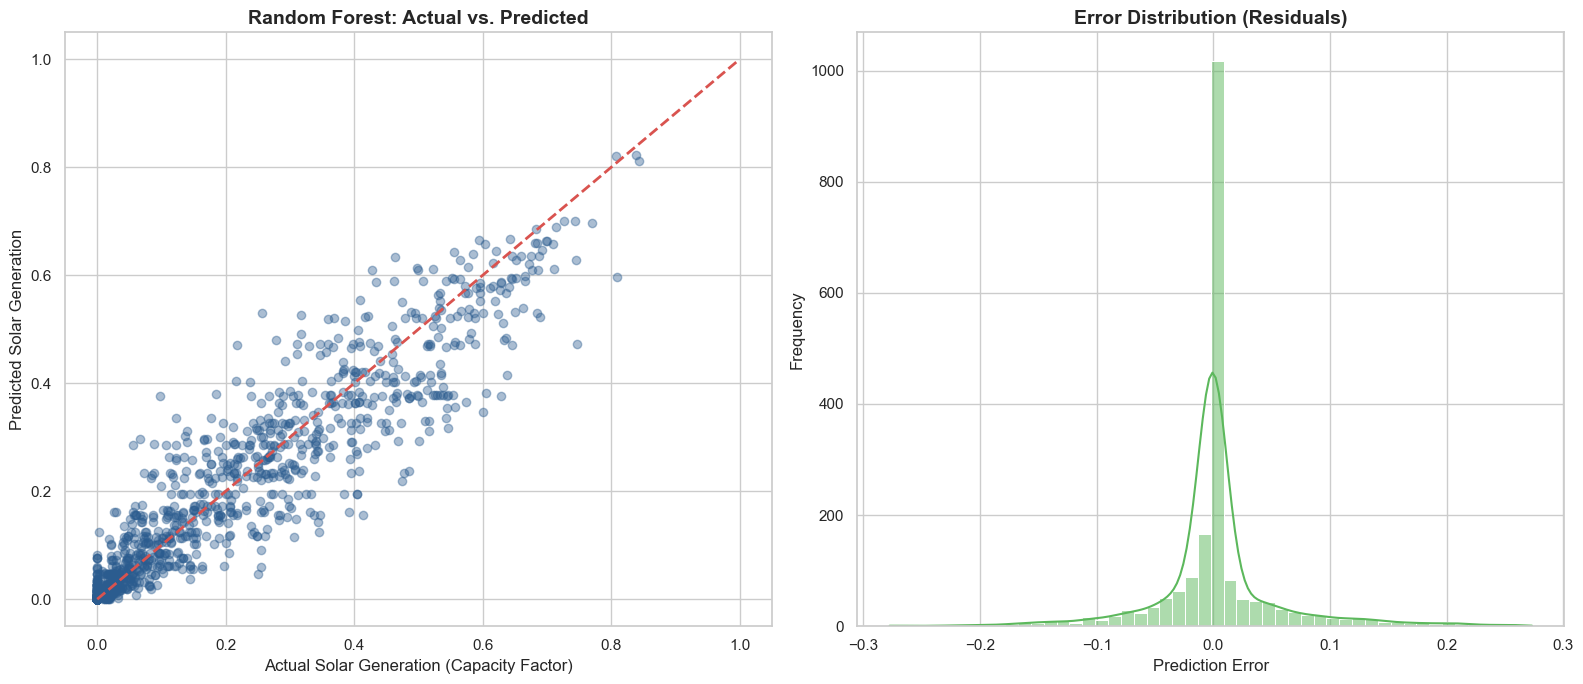

In [14]:
# Reload for RFR analysis
df_analysis_rfr = pd.read_csv('merged_encoded.csv')
df_analysis_rfr['Timestamp'] = pd.to_datetime(df_analysis_rfr['Timestamp'])

X = df_analysis_rfr.drop(columns=['Timestamp', 'Capacity_Factor'])
y = df_analysis_rfr['Capacity_Factor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)

model_rfr = joblib.load('solar_model_rfr.pkl')

# Figure 1: Model Accuracy & Error Analysis 

sns.set_theme(style="whitegrid")
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Actual vs Predicted
sample_indices = np.random.choice(len(y_test), size=2000, replace=False)
y_test_sample = y_test.iloc[sample_indices]
y_pred_sample = model_rfr.predict(X_test.iloc[sample_indices])

axes1[0].scatter(y_test_sample, y_pred_sample, alpha=0.4, color='#2b5c8f')
axes1[0].plot([0, 1], [0, 1], '--', color='#d9534f', linewidth=2)
axes1[0].set_title('Random Forest: Actual vs. Predicted', fontsize=14, fontweight='bold')
axes1[0].set_xlabel('Actual Solar Generation (Capacity Factor)')
axes1[0].set_ylabel('Predicted Solar Generation')

# Plot 2: Error Distribution (Residuals)
errors = y_test_sample - y_pred_sample
sns.histplot(errors, bins=50, kde=True, ax=axes1[1], color='#5cb85c')
axes1[1].set_title('Error Distribution (Residuals)', fontsize=14, fontweight='bold')
axes1[1].set_xlabel('Prediction Error')
axes1[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

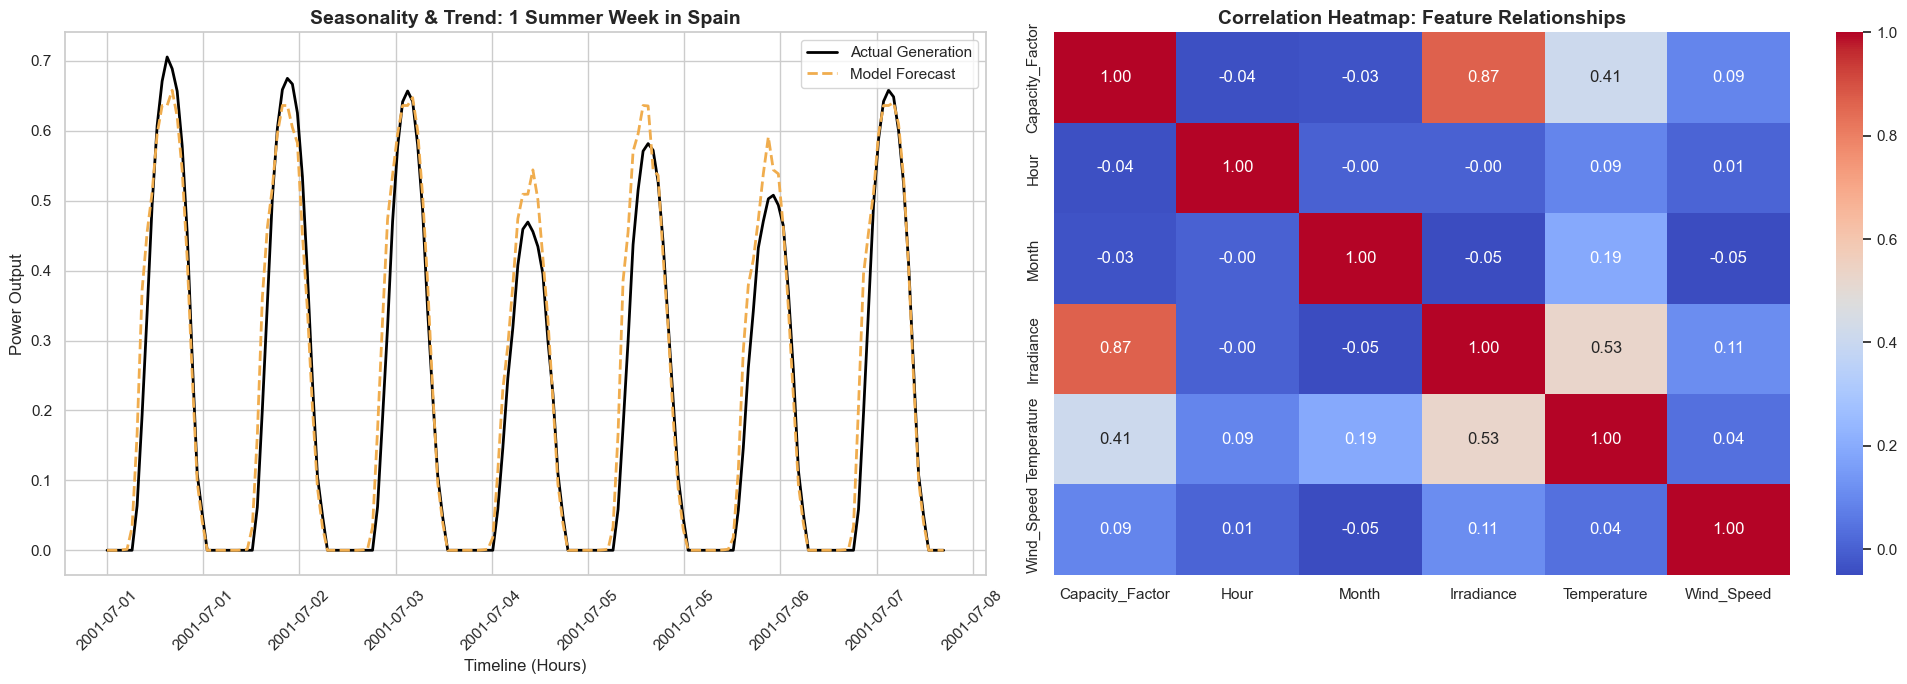

In [15]:
# Figure 2: Trends & Feature Relationships 

fig2, axes2 = plt.subplots(1, 2, figsize=(20, 7))

# Plot 3: Seasonality & Trends (1 Summer Week in Spain)
spain_summer = df_analysis_rfr[(df_analysis_rfr['Country_ES'] == 1) & (df_analysis_rfr['Month'] == 7)].head(168)
X_spain = spain_summer.drop(columns=['Timestamp', 'Capacity_Factor'])
y_true_spain = spain_summer['Capacity_Factor']
y_pred_spain = model_rfr.predict(X_spain)

axes2[0].plot(spain_summer['Timestamp'], y_true_spain, label='Actual Generation', color='black', linewidth=2)
axes2[0].plot(spain_summer['Timestamp'], y_pred_spain, label='Model Forecast', color='#f0ad4e', linestyle='dashed', linewidth=2)
axes2[0].set_title('Seasonality & Trend: 1 Summer Week in Spain', fontsize=14, fontweight='bold')
axes2[0].set_xlabel('Timeline (Hours)')
axes2[0].set_ylabel('Power Output')
axes2[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
axes2[0].tick_params(axis='x', rotation=45)
axes2[0].legend()

# Plot 4: Correlation Heatmap
cols_to_check = ['Capacity_Factor', 'Hour', 'Month', 'Irradiance', 'Temperature', 'Wind_Speed']
corr_matrix = df_analysis_rfr[cols_to_check].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes2[1], cbar=True)
axes2[1].set_title('Correlation Heatmap: Feature Relationships', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### **Interpreting the Random Forest Visualisations**

**Actual vs. Predicted:** Compared to the Linear Regression scatter, the Random Forest points should hug the diagonal more tightly, particularly at the extremes (very low and very high capacity factors). This reflects the model's ability to handle non-linear relationships.

**Error Distribution:** The residual histogram should be narrower and more sharply peaked at zero. The reduced spread indicates lower prediction error across the board.

**Seasonality Plot:** The Random Forest forecast line should overlay the actual generation curve more precisely, especially at the daily peaks and the sharp sunrise/sunset transitions that Linear Regression tends to smooth over.

**Correlation Heatmap:** This is data-dependent and remains identical across models. It confirms that Irradiance is the dominant predictor of solar output.

---
## **15. Custom Prediction Example**

To demonstrate practical usage, the trained models are used to predict solar generation for a custom scenario. The process involves:

1. Creating an empty row with all 34 feature columns set to 0.
2. Filling in the desired weather conditions and time of day.
3. Setting the appropriate country column to 1 (simulating One-Hot Encoding).
4. Passing the row to both models for prediction.

In [16]:
# Define simulated conditions
test_input = {
    'Hour': 13,               # 1:00 PM
    'Month': 7,               # July
    'Irradiance': 850.0,      # Strong sunlight (W/m^2)
    'Temperature': 32.0,      # Hot summer day (Celsius)
    'Wind_Speed': 2.5,        # Light breeze (m/s)
    'Country': 'Country_ES'   # Spain
}

# Create an empty row with all features set to 0
sample_row = pd.DataFrame(0, index=[0], columns=X.columns)

# Fill in the weather and time values
sample_row['Hour'] = test_input['Hour']
sample_row['Month'] = test_input['Month']
sample_row['Irradiance'] = test_input['Irradiance']
sample_row['Temperature'] = test_input['Temperature']
sample_row['Wind_Speed'] = test_input['Wind_Speed']

# Flip the country switch to 1 (One-Hot Encoding)
if test_input['Country'] in sample_row.columns:
    sample_row[test_input['Country']] = 1

# Predict using Linear Regression
lr_prediction = lr_model.predict(sample_row)[0]

# Predict using Random Forest
rfr_prediction = rfr_model.predict(sample_row)[0]

print(f"Scenario: {test_input['Country'].replace('Country_', '')} at {test_input['Hour']}:00 in Month {test_input['Month']}")
print(f"Weather: Irradiance={test_input['Irradiance']} W/m^2, Temp={test_input['Temperature']}C, Wind={test_input['Wind_Speed']} m/s")
print()
print(f"Linear Regression Prediction:     {lr_prediction:.4f} ({lr_prediction*100:.1f}% efficiency)")
print(f"Random Forest Prediction:         {rfr_prediction:.4f} ({rfr_prediction*100:.1f}% efficiency)")

Scenario: ES at 13:00 in Month 7
Weather: Irradiance=850.0 W/m^2, Temp=32.0C, Wind=2.5 m/s

Linear Regression Prediction:     0.6526 (65.3% efficiency)
Random Forest Prediction:         0.6262 (62.6% efficiency)


---
## **Summary**

This walkthrough covered the complete solar energy prediction pipeline:

| **Stage** | **Description** |
|---|---|
| Data Loading | Loaded the EMHIRES PV capacity factor dataset (29 countries, 1986-2015) |
| Visualisation | Plotted a single day's solar cycle to build intuition about the data |
| NASA Data Reference | Documented the weather data collection process via the NASA POWER API |
| Data Cleaning | Verified the absence of null values and sentinel flags in the raw data |
| Restructuring | Melted the wide format data into long format, created timestamps, extracted Hour and Month features |
| Merging | Fused generation data with NASA weather data using a composite Timestamp+Country key |
| Encoding | Applied One-Hot Encoding to convert country labels into 29 binary features |
| Linear Regression | Trained and evaluated a linear model as the baseline |
| Random Forest | Trained and evaluated a non-linear ensemble model for comparison |
| Analysis | Generated diagnostic visualisations (scatter plots, residuals, seasonality, correlation heatmaps) for both models |
| Model Export | Saved both trained models as `.pkl` files for deployment |

**Key Takeaway:** The Random Forest Regressor consistently outperforms Linear Regression on this dataset because solar generation exhibits non-linear dependencies on time-of-day, weather conditions, and geographic location. The linear model provides a useful interpretable baseline, while the Random Forest captures the complex interactions needed for accurate forecasting.